In [140]:
import matplotlib.pyplot as pt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = True

## Data Analysis

In [141]:
input_dataframe = pd.read_csv('allYearLabeledHarangi.csv')

In [142]:
input_dataframe.head(100)

,Dates,Present Storage(TMC),Reservoir Level(TMC),Inflow,Outflow,MADIKERI,SOMWARPET,VIRAJPET,Label
0,2011-01-01,3.74,2835.900,142.0,0.0,0.0,0.0,0.0,4
1,2011-01-02,3.76,2836.090,239.0,0.0,0.0,0.0,0.0,0
2,2011-01-03,3.77,2836.220,166.0,0.0,0.0,0.0,0.0,3
3,2011-01-04,3.78,2836.310,118.0,0.0,0.0,0.0,0.0,3
4,2011-01-05,3.79,2836.410,130.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
95,2011-04-06,4.00,2838.350,28.0,300.0,0.0,0.0,0.0,0
96,2011-04-07,3.98,2838.160,38.0,250.0,0.0,0.0,0.0,0
97,2011-04-08,3.95,2837.915,32.5,275.0,0.0,0.0,0.0,0
98,2011-04-09,3.92,2837.670,27.0,300.0,0.0,0.0,0.0,0


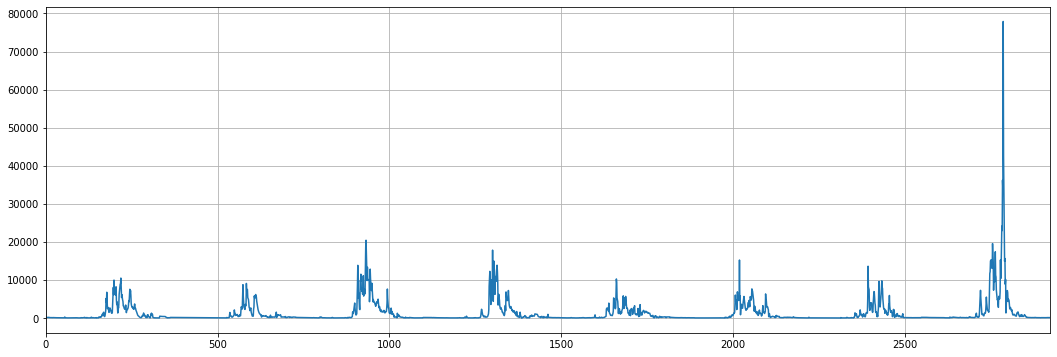

In [143]:
input_dataframe.Inflow.plot(kind='line')

In [144]:
input_dataframe.drop('Label', axis=1, inplace=True)

## Dataset Creation

### Label creation 

In [145]:
def sense_val_inflow(x):
    if(x <= 500):
        return 1
    elif((x > 500) and (x<=1000)):
        return 2
    elif((x > 1000) and (x<=2500)):
        return 3
    elif((x > 2500) and (x<=5000)):
        return 4
    elif((x > 5000) and (x <= 11000)):
        return 5
    elif(x > 11000):
         return 6

'''
         and (x <= 20000)):
         elif((x > 20000) and (x <= 30000)):
        return 7
    elif((x > 30000) and (x <= 40000)):
        return 8
    elif((x > 40000) and (x <= 50000)):
        return 9
    elif((x > 50000) and (x <= 70000)):
        return 10
    elif(x > 70000):
        return 11
'''

'\n         and (x <= 20000)):\n         elif((x > 20000) and (x <= 30000)):\n        return 7\n    elif((x > 30000) and (x <= 40000)):\n        return 8\n    elif((x > 40000) and (x <= 50000)):\n        return 9\n    elif((x > 50000) and (x <= 70000)):\n        return 10\n    elif(x > 70000):\n        return 11\n'

In [146]:
input_dataframe['Label'] = input_dataframe.Inflow.apply(sense_val_inflow)

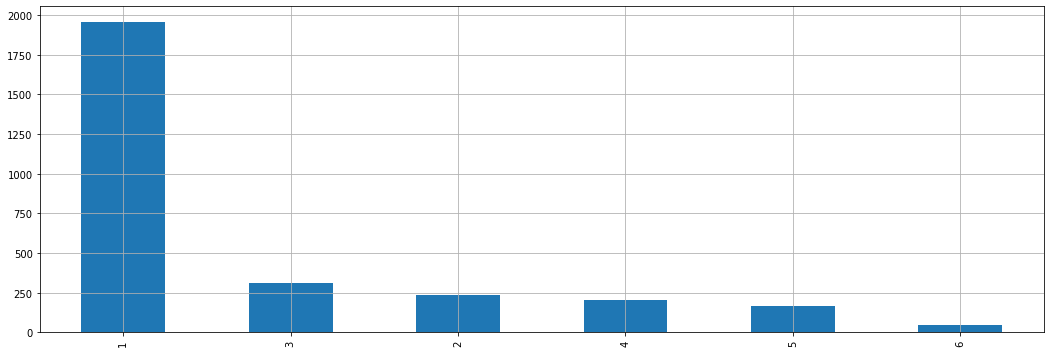

In [147]:
input_dataframe.Label.value_counts().plot(kind='bar')

In [148]:
input_dataframe.shape

(2922, 9)

In [149]:
input_dataframe.Label.value_counts()[1]/input_dataframe.shape[0]

0.6697467488021903

In [150]:
input_dataframe.columns

Index(['Dates', 'Present Storage(TMC)', 'Reservoir Level(TMC)', 'Inflow',
       'Outflow', 'MADIKERI', 'SOMWARPET', 'VIRAJPET', 'Label'],
      dtype='object')

In [151]:
input_dataframe['month'] = pd.DatetimeIndex(input_dataframe['Dates']).month
input_dataframe['year'] = pd.DatetimeIndex(input_dataframe['Dates']).year

In [152]:
input_dataframe.head()

,Dates,Present Storage(TMC),Reservoir Level(TMC),Inflow,Outflow,MADIKERI,SOMWARPET,VIRAJPET,Label,month,year
0,2011-01-01,3.74,2835.90,142.0,0.0,0.0,0.0,0.0,1,1,2011
1,2011-01-02,3.76,2836.09,239.0,0.0,0.0,0.0,0.0,1,1,2011
2,2011-01-03,3.77,2836.22,166.0,0.0,0.0,0.0,0.0,1,1,2011
3,2011-01-04,3.78,2836.31,118.0,0.0,0.0,0.0,0.0,1,1,2011
4,2011-01-05,3.79,2836.41,130.0,0.0,0.0,0.0,0.0,1,1,2011


##### Converting pandas series into timeseries

In [153]:
'''
In this method, we use all the lag days and lead days and construct a dataframe, where
the lag and lead days are represented in a single row
Using these features we can predict the class of the present day with the data from the previous days
This holds good for all the rows in the dataframe
'''

#dataset preparation with lag
def series_to_supervised(data, lag_days=1, lead_days=1, dropnan=True):
    no_of_features = 1 if type(data) is list else data.shape[1]
    print(no_of_features)
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(lag_days, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(no_of_features)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, lead_days):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(no_of_features)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(no_of_features)]
# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [154]:
input_dataframe_train = input_dataframe.loc[(input_dataframe['year'] <=2017) & (input_dataframe['month'] <= 12)]
input_dataframe_train.set_index(input_dataframe_train['Dates'], inplace=True)
input_dataframe_train = input_dataframe_train[['MADIKERI', 'SOMWARPET', 'VIRAJPET', 'Label']]
input_dataframe_test = input_dataframe.loc[(input_dataframe['year'] > 2017)]
input_dataframe_test.set_index(input_dataframe_test['Dates'], inplace=True)
input_dataframe_test = input_dataframe_test[['MADIKERI', 'SOMWARPET', 'VIRAJPET', 'Label']]

In [155]:
input_dataframe_train.head()

,MADIKERI,SOMWARPET,VIRAJPET,Label
Dates,,,,
2011-01-01,0.0,0.0,0.0,1
2011-01-02,0.0,0.0,0.0,1
2011-01-03,0.0,0.0,0.0,1
2011-01-04,0.0,0.0,0.0,1
2011-01-05,0.0,0.0,0.0,1


In [156]:
input_dataframe_test.head()

,MADIKERI,SOMWARPET,VIRAJPET,Label
Dates,,,,
2018-01-01,0.040023,0.922238,0.0,1
2018-01-02,0.040669,0.937113,0.0,1
2018-01-03,0.041315,0.951987,0.0,1
2018-01-04,0.041960,0.966862,0.0,1
2018-01-05,0.042606,0.981737,0.0,1


### Creating dataframe for Training data

In [157]:
lead_lag_dataframe_train = series_to_supervised(input_dataframe_train.values.astype('float64'), lag_days=2, lead_days=1, dropnan=True)
lead_columns = lead_lag_dataframe_train.filter(regex='var.\\(t\\)').columns
lead_columns_dataframe_train = lead_lag_dataframe_train[lead_columns]
lead_lag_dataframe_train.drop(labels=lead_columns, inplace=True, axis=1)
'''
Copying the label for the current day and keeping all the data from the previous days
'''
column_name = 'var4(t)'
lead_lag_dataframe_train[column_name] = lead_columns_dataframe_train[column_name]
lead_lag_dataframe_train.head()

4


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


### Creating dataframe for Testing data

In [158]:
lead_lag_dataframe_test = series_to_supervised(input_dataframe_test.values.astype('float64'), lag_days=2, lead_days=1, dropnan=True)
lead_columns_test = lead_lag_dataframe_test.filter(regex='var.\\(t\\)').columns
lead_columns_dataframe_test = lead_lag_dataframe_test[lead_columns_test]
lead_lag_dataframe_test.drop(labels=lead_columns_test, inplace=True, axis=1)
'''
Copying the label for the current day and keeping all the data from the previous days
'''
column_name = 'var4(t)'
lead_lag_dataframe_test[column_name] = lead_columns_dataframe_test[column_name]
lead_lag_dataframe_test.head()

4


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
2,0.040023,0.922238,0.0,1.0,0.040669,0.937113,0.0,1.0,1.0
3,0.040669,0.937113,0.0,1.0,0.041315,0.951987,0.0,1.0,1.0
4,0.041315,0.951987,0.0,1.0,0.041960,0.966862,0.0,1.0,1.0
5,0.041960,0.966862,0.0,1.0,0.042606,0.981737,0.0,1.0,1.0
6,0.042606,0.981737,0.0,1.0,0.043251,0.996612,0.0,1.0,1.0


## Machine Learning

### Train test split 

In [159]:
X_train = lead_lag_dataframe_train.loc[:, lead_lag_dataframe_train.columns != 'var4(t)']
y_train = lead_lag_dataframe_train.loc[:, lead_lag_dataframe_train.columns == 'var4(t)']
X_test = lead_lag_dataframe_test.loc[:, lead_lag_dataframe_test.columns != 'var4(t)']
y_test = lead_lag_dataframe_test.loc[:, lead_lag_dataframe_test.columns == 'var4(t)']

In [160]:
X_train, y_train

(      var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var1(t-1)  var2(t-1)  \
 2      0.000000   0.000000        0.0        1.0   0.000000   0.000000   
 3      0.000000   0.000000        0.0        1.0   0.000000   0.000000   
 4      0.000000   0.000000        0.0        1.0   0.000000   0.000000   
 5      0.000000   0.000000        0.0        1.0   0.000000   0.000000   
 6      0.000000   0.000000        0.0        1.0   0.000000   0.000000   
 ...         ...        ...        ...        ...        ...        ...   
 2552   0.035505   0.818114        0.0        1.0   0.036150   0.832989   
 2553   0.036150   0.832989        0.0        1.0   0.036796   0.847864   
 2554   0.036796   0.847864        0.0        1.0   0.037441   0.862739   
 2555   0.037441   0.862739        0.0        1.0   0.038087   0.877613   
 2556   0.038087   0.877613        0.0        1.0   0.038732   0.892488   
 
       var3(t-1)  var4(t-1)  
 2           0.0        1.0  
 3           0.0        1.0  
 4      

### Machine Learning with Eucliadian distance

In [161]:
#locally weighted regression
def lwr1(x0, inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    ypred = x0 * beta(x0, inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def beta(point, inp, out, k):
    wt = kernal(point, inp, k)
    #print("The weight of betas is",wt)
    #print("Weight * inp" , (inp.T * (wt*inp)).I)
    out = out.reshape((inp.shape[0],1))
#     print(inp.shape)
#     print(wt.shape)
#     print(out.shape)
    beta_val = (inp.T * (wt*inp)).I * inp.T * wt * out
    #print("The weight is beta value is",beta_val)
    return beta_val

def kernal(point, inp, k):
    l,b = np.shape(inp)
    weights = np.mat(np.eye((l)))
    #print(weights)    
    for i in range(l):
        #print(point.shape,inp[i].shape)
        diff = point - inp[i]
        weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
    return weights

In [162]:
# distance = np.array(distance)
# distance
# train_knn_y = distance[:,-1]
# train_knn_x = distance[:,:-1]
# print(train_knn_y.shape)
# print(train_knn_x.shape)

In [163]:
# train_knn_y = trai
# train_knn_x = distance[:,:-1]
# print(train_knn_y.shape)
# print(train_knn_x.shape)

In [164]:
print(X_train.shape,y_train.shape,X_test.shape)
ypred = []
for i in X_test.values:
    ypred.append(lwr1(i, X_train.values.astype('float32'), y_train.values.astype('float32'), 100))

(2555, 8) (2555, 1) (363, 8)


In [165]:
ypred = np.array(ypred).reshape((len(ypred),1))
ypred.shape

(363, 1)

In [166]:
Actuall_inflow=y_test
ypred.shape,Actuall_inflow.shape

((363, 1), (363, 1))

In [167]:
ypred = np.round(ypred)
df3 = pd.DataFrame()
df3['predicted'] = list(ypred)
df3['Actuall'] = Actuall_inflow
df3.to_csv(r"/home/ganesh/Downloads/choice_added_pred.csv") 
#print((ypred,Actuall_inflow))


In [174]:
print("MSE = ",metrics.mean_squared_error(Actuall_inflow,ypred))
#print("RMSE = ",sqrt(metrics.mean_squared_error(Actuall_inflow,train_knn_y)))
print("RMSE = ",sqrt(metrics.mean_squared_error(Actuall_inflow,ypred)))
print("Accuracy = " ,metrics.accuracy_score(Actuall_inflow,ypred))
print("Accuracy_lag = " ,metrics.accuracy_score(Actuall_inflow[0:-2],ypred[2:]))
#print("Accuracy_knn = " ,metrics.accuracy_score(Actuall_inflow,train_knn_y))
print("F1 Score_with_lag = ",metrics.f1_score(Actuall_inflow[0:-2],ypred[2:],average = 'weighted'))
print("F1 Score_no_lag = ",metrics.f1_score(Actuall_inflow,ypred,average = 'weighted'))

MSE =  0.15702479338842976
RMSE =  0.39626354032187944
Accuracy =  0.8677685950413223
Accuracy_lag =  0.8753462603878116
F1 Score_with_lag =  0.8763501517208678
F1 Score_no_lag =  0.8686821830610347


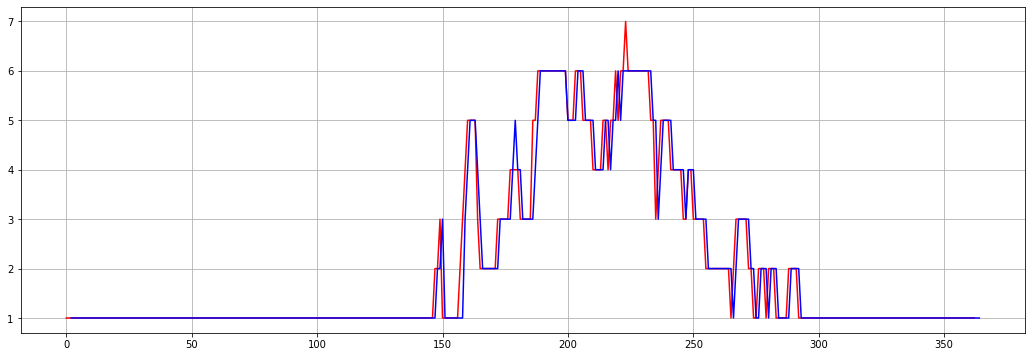

In [175]:
#pt.plot(train_knn_y,c='red')
pt.plot(ypred[:],c='red')
pt.plot(y_test[:],c='blue')

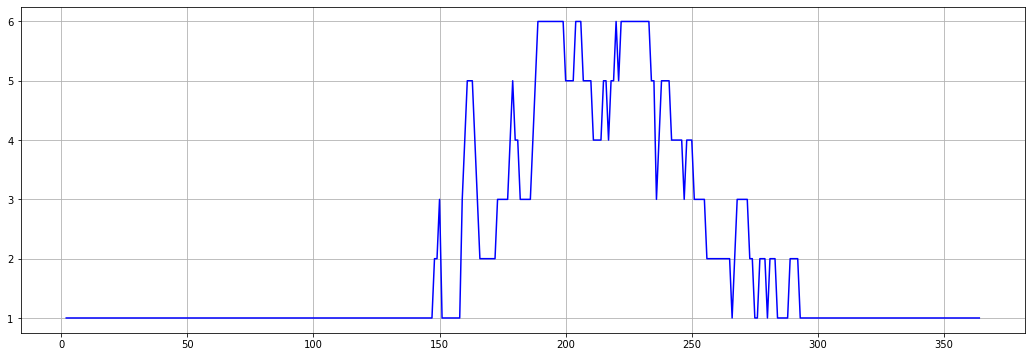

In [170]:
pt.plot(Actuall_inflow,c='blue')

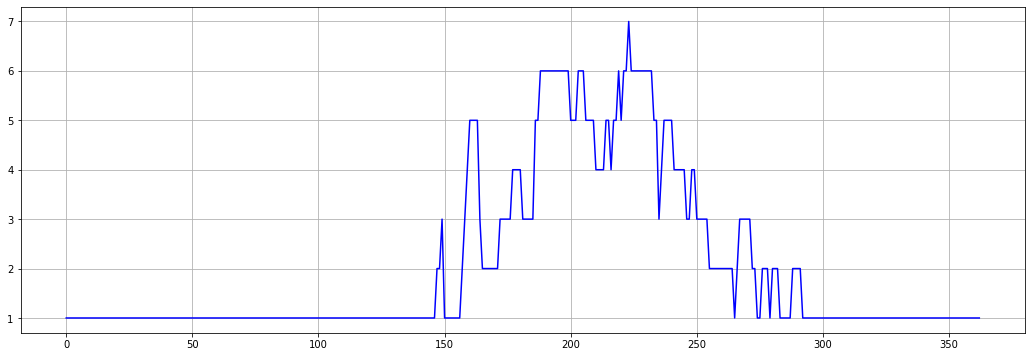

In [171]:
pt.plot(ypred,c='blue')

### Machine Learning with Stratified Sampling and KNN Regressor from Sklearn

Read links 
* [Link 1](https://explorable.com/stratified-sampling)
* [Link 2](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
